In [63]:
libraries = c("nleqslv","dplyr","magrittr","tidyr","rEDM","ggplot2","readxl",
              "gridExtra","zoo","scales")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE) }

# to show the plots as svg-graphics in Jupyter
options(jupyter.plot_mimetypes = "image/svg+xml") 

packageVersion('rEDM')

set.seed(599213)

'%&%' <- function(x,y)paste0(x,y)

[1] '0.6.5'

In [3]:
cntr = "Denmark"
df.long = read.csv('Sugihara2012_dataset.txt',header = TRUE)
df.long %<>%
    filter(country == cntr) %>% 
    filter(year >= 1996)

df.long %>% head

country,variable,year,month,day,value
Denmark,flu,1996,1,1,NaN
Denmark,flu,1996,1,8,NaN
Denmark,flu,1996,1,15,NaN
Denmark,flu,1996,1,22,NaN
Denmark,flu,1996,1,29,NaN
Denmark,flu,1996,2,5,NaN


In [4]:
df.in = df.long %>%
    select(-country) %>%
    spread(variable,value) %>%
    mutate(date = ISOdate(year,month,day)) %>%
    select(-year,-month,-day) %>%
    select(date,flu,everything())
df.in %>% head

date,flu,AH,PRCP,RH,T
1996-01-01 12:00:00,NaN,3.314742,6.60,0.827500,27.1
1996-01-08 12:00:00,NaN,4.991437,9.54,0.954702,34.0
1996-01-15 12:00:00,NaN,4.310679,8.50,0.928307,30.9
1996-01-22 12:00:00,NaN,3.044399,7.71,0.790498,26.1
1996-01-29 12:00:00,NaN,3.531248,7.20,0.878098,27.2
1996-02-05 12:00:00,NaN,2.367563,5.40,0.729602,21.8


In [5]:
make_block = function(data,cols,delays,lib=c(1,NROW(data))){
    lib = matrix(lib,ncol = 2)
    data = as.matrix(data)
    ncol = length(cols)
    nrow = dim(data)[1]
    block = array(NA,dim = c(nrow,ncol))
    colnames(block) = 1:ncol
    for (i in 1:ncol){
        I = 1:nrow
        I_delay <- intersect(I,I+delays[i])
        block[I_delay-delays[i],i] = data[I_delay,cols[i]]
        if (delays[i] < 0){
            # remove data points that fall at start of lib segments
            block[lib[,1] - (0:(delays[i]+1)),i] = NA
            colnames(block)[i] = paste(colnames(data)[cols[i]],'_t-',abs(delays[i]),sep="")
        } else if (delays[i] > 0) {
            # remove data points that fall at end of lib segments
            block[lib[,2] - (0:(delays[i]+1)),i] = NA
            colnames(block)[i] <- paste(colnames(data)[cols[i]],'_t+',abs(delays[i]),sep="")
        } else {
            colnames(block)[i] <- paste(colnames(data)[cols[i]],'_t',sep="")
        }
    }
    return(block)
}

We define a function **yearday_anom()** that computes the seasonal cycle and day-of-year
anomaly for a time-series. As described in the main text, this is done with smoothing splines.

Anomaly is the difference between the observed value and the smoothed spline.

In [6]:
yearday_anom = function(t,x){
    # t: date formatted with POSIXt
    # x: time-series values to compute seasonal mean and anomaly
    doy = as.numeric(strftime(t, format = "%j"))
    I_use = which(!is.na(x))
    # create time indices to use for smoothing, replicating data to "wrap around"
    doy_sm = rep(doy[I_use],3) + rep(c(-366,0,366),each=length(I_use))
    x_sm = rep(x[I_use],3)
    xsp = smooth.spline(doy_sm, y = x_sm, w = NULL, spar = 0.8, cv = NA,
        all.knots = TRUE,keep.data = TRUE, df.offset = 0)
    xbar = data.frame(t=t,doy=doy) %>%
        left_join(data.frame(doy=xsp$x,xbar=xsp$y),by='doy') %>%
        select(xbar)
    out = data.frame(t=t,mean=xbar,anomaly=(x - xbar))
    names(out) = c('date','mean','anomaly')
    return(out)
}

In [7]:
out = yearday_anom(df.in$date,df.in$AH)
AH.bar = out$mean
AH.tilde = out$anomaly

Warning message:
"Removed 4 rows containing missing values (geom_point)."

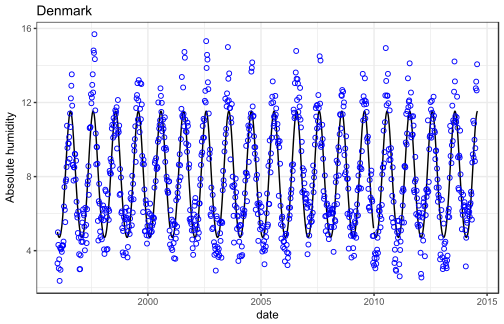

In [8]:
options(repr.plot.width=7,repr.plot.height=4.5)
out %>% 
    ggplot(aes(x=date)) +
        geom_line(aes(y=mean)) +
        geom_point(aes(y=mean+anomaly),color="blue",shape=1) +
        labs(x="date",y="Absolute humidity",title=cntr) +
        theme_bw() -> p1_Denmark

p1_Denmark

In [9]:
AH.surrs = do.call(cbind,
    lapply(1:500, function(i) {
        I_na = is.na(AH.tilde)
        out = AH.bar
        out[I_na] = NA
        out[!I_na] = out[!I_na] + sample(AH.tilde[!I_na],sum(!I_na),replace = FALSE)
        return(out)
    })
)

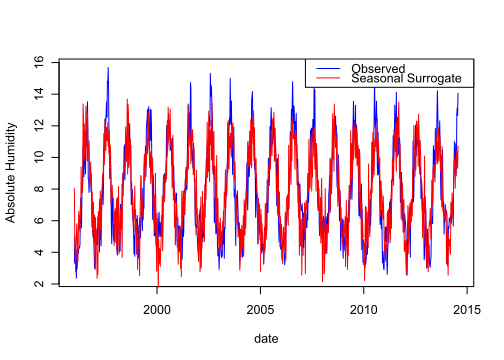

In [10]:
options(repr.plot.width=7,repr.plot.height=5)
plot(df.in$date,df.in$AH,type='l',col='blue',xlab='date',ylab='Absolute Humidity')
lines(df.in$date,AH.surrs[,1],col='red')
legend( x="topright", legend=c("Observed","Seasonal Surrogate"), col=c("blue","red"), lwd=1, lty=c(1,1),bg='white')

# 3. CCM

For set up, we need to determine the set of points to be predicted (pred input) to deal with the fact that many of the influenza time-series have strings of 0 counts. These strings will contain little or no causal information, and more practically can cause problems with how nearest neighbors are calculated for simplex projection when there are many 0 count vectors. We write a function that eliminates all vectors from the prediction that contain a string of at least $E$ 0’s.

In [11]:
make_pred_nozero = function(time_series,E) {
    I_zero_strings = which(time_series==0)
    I_zero_strings = Reduce(intersect, lapply((0:E),function(offset) I_zero_strings-offset))
    I_zero_strings = c(0,I_zero_strings,NROW(df.in)) # for convenience in next step
    N_zero_strings = length(I_zero_strings)
    lib_nozeroes = cbind(I_zero_strings[1:(N_zero_strings-1)]+1,I_zero_strings[2:(N_zero_strings)]-1)
    lib_out = lib_nozeroes[which(lib_nozeroes[,2] > lib_nozeroes[,1]),]
    return(lib_out)
}

In [12]:
df.in %>% mutate(index=1:n()) %>% filter(index>=600&index<615)

date,flu,AH,PRCP,RH,T,index
2007-06-25 12:00:00,NaN,10.598504,55.70,0.867344,57.60,600
2007-07-02 12:00:00,NaN,11.874325,69.20,0.898884,59.90,601
2007-07-09 12:00:00,NaN,10.996224,59.64,0.846580,59.40,602
2007-07-16 12:00:00,NaN,12.403229,19.48,0.835184,63.40,603
2007-07-23 12:00:00,NaN,11.702477,40.23,0.847995,61.20,604
2007-07-30 12:00:00,NaN,10.683401,42.80,0.779359,61.00,605
2007-08-06 12:00:00,NaN,14.497789,12.50,0.862870,67.15,606
2007-08-13 12:00:00,NaN,11.939355,52.16,0.806622,63.30,607
2007-08-20 12:00:00,NaN,14.267609,11.34,0.915726,64.85,608
2007-08-27 12:00:00,NaN,9.605718,26.29,0.818989,56.40,609


In [13]:
I_zero_strings = which(df.in$flu==0)
I_zero_strings

[1]  59  61 106 107 109 118 119 139 140 141 142 143 144 145 146 147 148 149
 [19] 150 154 167 168 170 191 192 193 194 195 196 197 198 199 200 201 203 204
 [37] 205 216 218 219 220 221 222 248 249 250 251 252 253 254 255 256 257 258
 [55] 260 262 275 276 277 278 279 300 301 302 303 304 305 306 307 308 309 310
 [73] 311 312 313 314 319 326 327 328 329 330 331 352 353 354 355 356 357 358
 [91] 359 360 361 362 363 364 365 366 367 379 380 381 382 383 384 404 405 406
[109] 407 408 409 410 411 422 423 426 428 430 431 432 433 434 435 436 457 458
[127] 459 460 461 462 463 464 465 466 467 510 511 512 513 514 515 516 517 518
[145] 519 520 521 522 523 525 538 539 562 563 564 565 566 567 568 569 570 571
[163] 572 573 574 575 578 591 592 593 594 615 616 617 618 619 620 622 625 643
[181] 644 665 666 667 668 669 671 740 751 752 753 754 755 756 758 759 760 761
[199] 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 802 804 805
[217] 806 808 809 810 811 812 814 815 816 817 820 823 824 825 826 827 828 830
[235] 832 833 834 835 836 837 838 839 855 857 858 859 860 861 862 863 864 865
[253] 866 867 868 869 870 872 873 876 908 909 911 913 916 918 919 920 921 922
[271] 923 924 925 926

In [14]:
I_zero_strings2 = Reduce(intersect, lapply((0:5),function(offset) I_zero_strings-offset))
I_zero_strings2

[1] 139 140 141 142 143 144 145 191 192 193 194 195 196 248 249 250 251 252
 [19] 253 300 301 302 303 304 305 306 307 308 309 326 352 353 354 355 356 357
 [37] 358 359 360 361 362 379 404 405 406 430 431 457 458 459 460 461 462 510
 [55] 511 512 513 514 515 516 517 518 562 563 564 565 566 567 568 569 570 615
 [73] 751 758 759 760 761 762 763 764 765 766 767 768 769 770 771 823 832 833
 [91] 834 857 858 859 860 861 862 863 864 865 918 919 920 921

In [15]:
lapply((0:8),function(offset) I_zero_strings-offset)

[[1]]
  [1]  59  61 106 107 109 118 119 139 140 141 142 143 144 145 146 147 148 149
 [19] 150 154 167 168 170 191 192 193 194 195 196 197 198 199 200 201 203 204
 [37] 205 216 218 219 220 221 222 248 249 250 251 252 253 254 255 256 257 258
 [55] 260 262 275 276 277 278 279 300 301 302 303 304 305 306 307 308 309 310
 [73] 311 312 313 314 319 326 327 328 329 330 331 352 353 354 355 356 357 358
 [91] 359 360 361 362 363 364 365 366 367 379 380 381 382 383 384 404 405 406
[109] 407 408 409 410 411 422 423 426 428 430 431 432 433 434 435 436 457 458
[127] 459 460 461 462 463 464 465 466 467 510 511 512 513 514 515 516 517 518
[145] 519 520 521 522 523 525 538 539 562 563 564 565 566 567 568 569 570 571
[163] 572 573 574 575 578 591 592 593 594 615 616 617 618 619 620 622 625 643
[181] 644 665 666 667 668 669 671 740 751 752 753 754 755 756 758 759 760 761
[199] 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 802 804 805
[217] 806 808 809 810 811 812 814 815 816 817 820 823 824 825 826 827 828 830
[235] 832 833 834 835 836 837 838 839 855 857 858 859 860 861 862 863 864 865
[253] 866 867 868 869 870 872 873 876 908 909 911 913 916 918 919 920 921 922
[271] 923 924 925 926

[[2]]
  [1]  58  60 105 106 108 117 118 138 139 140 141 142 143 144 145 146 147 148
 [19] 149 153 166 167 169 190 191 192 193 194 195 196 197 198 199 200 202 203
 [37] 204 215 217 218 219 220 221 247 248 249 250 251 252 253 254 255 256 257
 [55] 259 261 274 275 276 277 278 299 300 301 302 303 304 305 306 307 308 309
 [73] 310 311 312 313 318 325 326 327 328 329 330 351 352 353 354 355 356 357
 [91] 358 359 360 361 362 363 364 365 366 378 379 380 381 382 383 403 404 405
[109] 406 407 408 409 410 421 422 425 427 429 430 431 432 433 434 435 456 457
[127] 458 459 460 461 462 463 464 465 466 509 510 511 512 513 514 515 516 517
[145] 518 519 520 521 522 524 537 538 561 562 563 564 565 566 567 568 569 570
[163] 571 572 573 574 577 590 591 592 593 614 615 616 617 618 619 621 624 642
[181] 643 664 665 666 667 668 670 739 750 751 752 753 754 755 757 758 759 760
[199] 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 801 803 804
[217] 805 807 808 809 810 811 813 814 815 816 819 822 823 824 825 826 827 829
[235] 831 832 833 834 835 836 837 838 854 856 857 858 859 860 861 862 863 864
[253] 865 866 867 868 869 871 872 875 907 908 910 912 915 917 918 919 920 921
[271] 922 923 924 925

[[3]]
  [1]  57  59 104 105 107 116 117 137 138 139 140 141 142 143 144 145 146 147
 [19] 148 152 165 166 168 189 190 191 192 193 194 195 196 197 198 199 201 202
 [37] 203 214 216 217 218 219 220 246 247 248 249 250 251 252 253 254 255 256
 [55] 258 260 273 274 275 276 277 298 299 300 301 302 303 304 305 306 307 308
 [73] 309 310 311 312 317 324 325 326 327 328 329 350 351 352 353 354 355 356
 [91] 357 358 359 360 361 362 363 364 365 377 378 379 380 381 382 402 403 404
[109] 405 406 407 408 409 420 421 424 426 428 429 430 431 432 433 434 455 456
[127] 457 458 459 460 461 462 463 464 465 508 509 510 511 512 513 514 515 516
[145] 517 518 519 520 521 523 536 537 560 561 562 563 564 565 566 567 568 569
[163] 570 571 572 573 576 589 590 591 592 613 614 615 616 617 618 620 623 641
[181] 642 663 664 665 666 667 669 738 749 750 751 752 753 754 756 757 758 759
[199] 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 800 802 803
[217] 804 806 807 808 809 810 812 813 814 815 818 821 822 823 824 825 826 828
[235] 830 831 832 833 834 835 836 837 853 855 856 857 858 859 860 861 862 863
[253] 864 865 866 867 868 870 871 874 906 907 909 911 914 916 917 918 919 920
[271] 921 922 923 924

[[4]]
  [1]  56  58 103 104 106 115 116 136 137 138 139 140 141 142 143 144 145 146
 [19] 147 151 164 165 167 188 189 190 191 192 193 194 195 196 197 198 200 201
 [37] 202 213 215 216 217 218 219 245 246 247 248 249 250 251 252 253 254 255
 [55] 257 259 272 273 274 275 276 297 298 299 300 301 302 303 304 305 306 307
 [73] 308 309 310 311 316 323 324 325 326 327 328 349 350 351 352 353 354 355
 [91] 3

**Reduce** is from the functional programming module of *R*

In [16]:
I_zero_strings = I_zero_strings2
I_zero_strings = c(0,I_zero_strings,NROW(df.in)) # for convenience in next step
I_zero_strings

[1]   0 139 140 141 142 143 144 145 191 192 193 194 195 196 248 249 250 251
 [19] 252 253 300 301 302 303 304 305 306 307 308 309 326 352 353 354 355 356
 [37] 357 358 359 360 361 362 379 404 405 406 430 431 457 458 459 460 461 462
 [55] 510 511 512 513 514 515 516 517 518 562 563 564 565 566 567 568 569 570
 [73] 615 751 758 759 760 761 762 763 764 765 766 767 768 769 770 771 823 832
 [91] 833 834 857 858 859 860 861 862 863 864 865 918 919 920 921 970

In [17]:
N_zero_strings = length(I_zero_strings)
N_zero_strings

[1] 106

In [18]:
lib_nozeroes = cbind(I_zero_strings[1:(N_zero_strings-1)]+1,I_zero_strings[2:(N_zero_strings)]-1)
lib_nozeroes %>% head(16)

1,138
140,139
141,140
142,141
143,142
144,143
145,144
146,190
192,191
193,192
194,193


In [19]:
lib_out = lib_nozeroes[which(lib_nozeroes[,2] > lib_nozeroes[,1]),]
lib_out

1,138
146,190
197,247
254,299
310,325
327,351
363,378
380,403
407,429
432,456
463,509


## 3.a Determine optimal $E$ for CCM

We now determine the proper embedding dimension for cross-mapping following the procedure of Deyle et al. (2016). We determine $E^*$ that gives optimal prediction of cross-mapping lagged 1 week. Note that we specificy the lib_size to be the largest possible number of points in the library (even though the actual number will be smaller because of NAs and the zero strings). This is for convenience so that the code will automatically use the largest possible lib_size.

In [20]:
block_temp = df.in %>% select(flu,AH)
lib_ccm = c(1,NROW(df.in))

Emax=8

out.temp = do.call(
    rbind,
    lapply(1:Emax, function(E_i) {
        pred_ccm = make_pred_nozero(block_temp$flu,E_i)
        ccm(block=block_temp,
            E=E_i,
            lib=lib_ccm,
            pred=pred_ccm,
            lib_sizes = NROW(block_temp),
            exclusion_radius=0,
            random_libs = FALSE,
            num_sample=1,
            tp = -1,
            lib_column = 1,
            target_column = 2, 
            silent = TRUE) }
    )
)

out.temp

E,tau,tp,num_neighbors,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
1,1,-1,2,1,2,614,400,0.17910471,1.843047,2.501677
2,1,-1,3,1,2,594,400,0.05135658,1.951606,2.597812
3,1,-1,4,1,2,577,399,0.22749008,1.751233,2.342287
4,1,-1,5,1,2,559,399,0.04313842,1.883103,2.497428
5,1,-1,6,1,2,542,406,0.06881939,2.056252,2.737585
6,1,-1,7,1,2,526,416,0.29636337,1.700103,2.285878
7,1,-1,8,1,2,510,415,0.34598041,1.645424,2.229613
8,1,-1,9,1,2,494,415,0.32404071,1.673133,2.290292


In [21]:
E_star = out.temp$E[which.max(out.temp$rho)]
E_star

[1] 7

## 3.b Calculate CCM for real data

We then measure the un-lagged cross-map skill with this value of $E^*$.

In [22]:
pred_ccm = make_pred_nozero(block_temp$flu,E_star)
df.out.ccm = ccm(block=block_temp,
                    E=E_star,
                    lib=lib_ccm,
                    pred = pred_ccm,
                    lib_sizes = NROW(block_temp),
                    exclusion_radius=0,
                    random_libs = FALSE,
                    num_sample=1,
                    tp = 0, 
                    silent = TRUE)
df.out.ccm

In [23]:
df.out.ccm.surr = data.frame()

for (i_surr in 1:dim(AH.surrs)[2]) {
    block_temp = data.frame(flu=df.in$flu,AH=AH.surrs[,i_surr])
    out.temp = do.call(
        rbind,
        lapply(1:8, function(E_i){
            pred_ccm = make_pred_nozero(block_temp$flu,E_i)
            ccm(block=block_temp,
                E=E_i,
                lib=lib_ccm,
                pred=pred_ccm,
                lib_sizes = NROW(block_temp),
                exclusion_radius=0,
                random_libs = FALSE,
                num_sample=1,
                tp = -1,
                lib_column = 1,
                target_column = 2, 
                silent=TRUE)
            }
        )
    )
    
    E_star = out.temp$E[which.max(out.temp$rho)]
    pred_ccm = make_pred_nozero(block_temp$flu,E_star)
    out.temp = ccm(block = block_temp,
                    E = E_star,
                    lib = lib_ccm,
                    pred = pred_ccm,
                    lib_sizes = NROW(block_temp),
                    exclusion_radius = 0,
                    random_libs = FALSE,
                    num_sample=1,
                    tp = 0,
                    silent=TRUE)
    df.out.ccm.surr <- df.out.ccm.surr %>% bind_rows(out.temp)
} # for i_surr

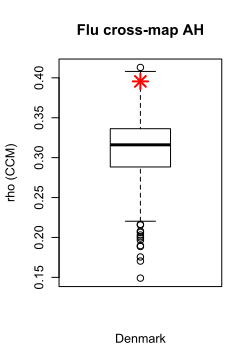

In [24]:
options(repr.plot.width=3.5,repr.plot.height=5)
boxplot(df.out.ccm.surr$rho, ylab='rho (CCM)', xlab=cntr, main='Flu cross-map AH')
points(1,df.out.ccm$rho, pch=8, col='red', cex=2, lwd=2)

In [25]:
df.out.ccm

E,tau,tp,num_neighbors,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
7,1,0,8,1,2,510,415,0.3955595,1.560958,2.186334


# Same for Japan

In [26]:
cntr = "Japan"
read.csv('Sugihara2012_dataset.txt',header = TRUE) %>%
    filter(country == cntr) %>% # Change here to produce results for other countries
    filter(year >= 1997) %>%
    select(-country) %>%
    spread(variable,value) %>%
    mutate(date = ISOdate(year,month,day)) %>%
    select(-year,-month,-day) %>%
    select(date,flu,everything()) -> df.in

df.in %>% head

date,flu,AH,PRCP,RH,T
1997-01-01 12:00:00,0.000421,4.145341,0.20,0.636837,39.85
1997-01-08 12:00:00,0.002708,4.052195,14.20,0.613402,40.25
1997-01-15 12:00:00,0.004121,4.094306,0.58,0.576953,42.20
1997-01-22 12:00:00,0.003152,4.043828,5.93,0.611007,40.30
1997-01-29 12:00:00,0.001651,3.713377,12.00,0.599750,38.50
1997-02-05 12:00:00,0.001318,4.257877,24.50,0.613325,41.60


Warning message:
"Removed 4 rows containing missing values (geom_point)."

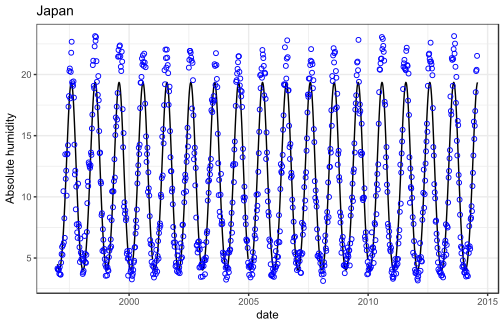

In [27]:
out = yearday_anom(df.in$date,df.in$AH)
AH.bar = out$mean
AH.tilde = out$anomaly

options(repr.plot.width=7,repr.plot.height=4.5)
out %>% 
    ggplot(aes(x=date)) +
        geom_line(aes(y=mean)) +
        geom_point(aes(y=mean+anomaly),color="blue",shape=1) +
        labs(x="date",y="Absolute humidity",title=cntr) + theme_bw()

Warning message:
"Removed 4 rows containing missing values (geom_point)."

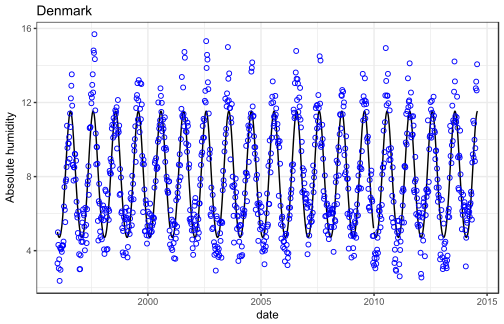

In [28]:
p1_Denmark

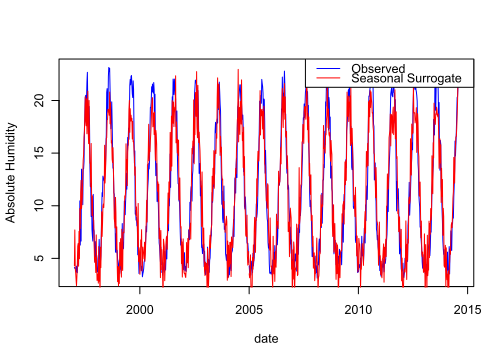

In [29]:
AH.surrs = do.call(cbind,
    lapply(1:500, function(i) {
        I_na = is.na(AH.tilde)
        out = AH.bar
        out[I_na] = NA
        out[!I_na] = out[!I_na] + sample(AH.tilde[!I_na],sum(!I_na),replace = FALSE)
        return(out)
    })
)
options(repr.plot.width=7,repr.plot.height=5)
plot(df.in$date,df.in$AH,type='l',col='blue',xlab='date',ylab='Absolute Humidity')
lines(df.in$date,AH.surrs[,1],col='red')
legend( x="topright", legend=c("Observed","Seasonal Surrogate"), col=c("blue","red"), lwd=1, lty=c(1,1),bg='white')

In [30]:
block_temp = df.in %>% select(flu,AH)
lib_ccm = c(1,NROW(df.in))

Emax=8

out.temp = do.call(
    rbind,
    lapply(1:Emax, function(E_i) {
        pred_ccm = make_pred_nozero(block_temp$flu,E_i)
        ccm(block=block_temp,
            E=E_i,
            lib=lib_ccm,
            pred=pred_ccm,
            lib_sizes = NROW(block_temp),
            exclusion_radius=0,
            random_libs = FALSE,
            num_sample=1,
            tp = -1,
            lib_column = 1,
            target_column = 2, 
            silent = TRUE) }
    )
)

out.temp

E,tau,tp,num_neighbors,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
1,1,-1,2,1,2,860,774,0.6223321,3.450131,4.783725
2,1,-1,3,1,2,853,779,0.5760322,3.653502,5.079655
3,1,-1,4,1,2,849,786,0.6306740,3.432822,4.801070
4,1,-1,5,1,2,845,794,0.6420185,3.408546,4.788002
5,1,-1,6,1,2,841,798,0.6585045,3.359916,4.775487
6,1,-1,7,1,2,837,799,0.7197733,3.096810,4.295376
7,1,-1,8,1,2,833,801,0.7479067,2.924831,4.113683
8,1,-1,9,1,2,829,797,0.7659016,2.817018,3.988035


In [31]:
E_star = out.temp$E[which.max(out.temp$rho)]
E_star

[1] 8

In [32]:
pred_ccm = make_pred_nozero(block_temp$flu,E_star)
df.out.ccm = ccm(block=block_temp,
                    E=E_star,
                    lib=lib_ccm,
                    pred = pred_ccm,
                    lib_sizes = NROW(block_temp),
                    exclusion_radius=0,
                    random_libs = FALSE,
                    num_sample=1,
                    tp = 0, 
                    silent = TRUE)
df.out.ccm

E,tau,tp,num_neighbors,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
8,1,0,9,1,2,829,797,0.7529563,2.895422,4.080456


In [33]:
df.out.ccm.surr = data.frame()

for (i_surr in 1:dim(AH.surrs)[2]) {
    block_temp = data.frame(flu=df.in$flu,AH=AH.surrs[,i_surr])
    out.temp = do.call(
        rbind,
        lapply(1:8, function(E_i){
            pred_ccm = make_pred_nozero(block_temp$flu,E_i)
            ccm(block=block_temp,
                E=E_i,
                lib=lib_ccm,
                pred=pred_ccm,
                lib_sizes = NROW(block_temp),
                exclusion_radius=0,
                random_libs = FALSE,
                num_sample=1,
                tp = -1,
                lib_column = 1,
                target_column = 2, 
                silent=TRUE)
            }
        )
    )
    
    E_star = out.temp$E[which.max(out.temp$rho)]
    pred_ccm = make_pred_nozero(block_temp$flu,E_star)
    out.temp = ccm(block = block_temp,
                    E = E_star,
                    lib = lib_ccm,
                    pred = pred_ccm,
                    lib_sizes = NROW(block_temp),
                    exclusion_radius = 0,
                    random_libs = FALSE,
                    num_sample=1,
                    tp = 0,
                    silent=TRUE)
    df.out.ccm.surr <- df.out.ccm.surr %>% bind_rows(out.temp)
}

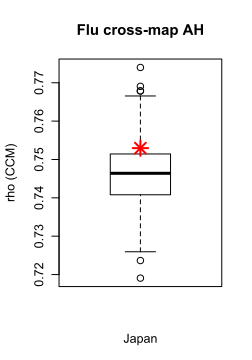

In [34]:
options(repr.plot.width=3.5,repr.plot.height=5)
boxplot(df.out.ccm.surr$rho, ylab='rho (CCM)', xlab=cntr, main='Flu cross-map AH')
points(1,df.out.ccm$rho, pch=8, col='red', cex=2, lwd=2)

In [57]:
qs=c(.05,.25, .5, .75,.95)
data.frame(value=quantile(df.out.ccm.surr$rho, qs)) -> df
df$names <- paste0("q",rownames(df))
df %>%
    mutate(names=substr(names,1,nchar(names)-1)) %>%
    spread(names,value) %>%
    mutate(Country=cntr)

q25,q5,q50,q75,q95,Country
0.7408005,0.7318429,0.7463971,0.7514336,0.7595916,Japan


# For prefectures

In [107]:
yearMin = 2001
yrs = read.csv('Japan_by_prefecture.csv',header = TRUE) %>% 
    select(Year) %>%
    unique %>%
    filter(Year>=yearMin) %>%
    .$Year
yrs

[1] 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
[16] 2016 2017

In [108]:
getMondays = function(year) {
    return(seq(as.Date(year%&%'-01-01'),as.Date(year%&%'-12-31'),'days')%>%.[weekdays(.)=='Monday']) }

Calendar = c()
for(yr in yrs %>% as.numeric) 
    Calendar %<>% 
        rbind(as.data.frame(list(date=NA,Year=yr,Week=1:length(getMondays(yr))))) %>%
        rowwise() %>% 
        mutate(date=getMondays(Year)[Week]) 
tail(Calendar)

date,Year,Week
2017-11-20,2017,47
2017-11-27,2017,48
2017-12-04,2017,49
2017-12-11,2017,50
2017-12-18,2017,51
2017-12-25,2017,52


In [109]:
prefect="Okinawa"
df.in = read.csv('Japan_by_prefecture.csv',header = TRUE) %>%
    filter(Prefecture == prefect) %>%
    select(-Prefecture) %>%
    filter(Year>=yearMin) %>%
    left_join(Calendar) %>%
    select(-Year,-Week) %>%
    rename(flu=Flu) %>%
    select(date,flu,everything()) -> df.in

df.in %>% head

Joining, by = c("Year", "Week")


date,flu,T,SH
2001-01-01,0.3793103,20.44714,0.01191430
2001-01-08,0.5862069,19.85143,0.01159716
2001-01-15,0.8103448,19.12571,0.01061716
2001-01-22,0.8448276,21.03000,0.01304716
2001-01-29,0.5172414,20.62429,0.01204431
2001-02-05,0.4310345,20.56429,0.01255574


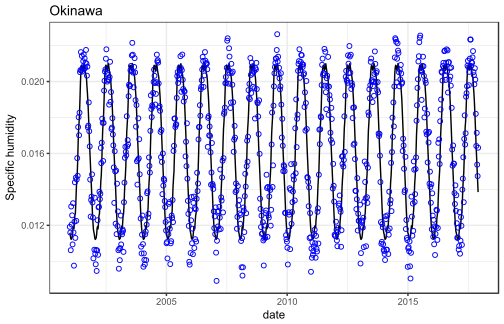

In [110]:
out = yearday_anom(df.in$date,df.in$SH)
SH.bar = out$mean
SH.tilde = out$anomaly

options(repr.plot.width=7,repr.plot.height=4.5)
out %>% 
    ggplot(aes(x=date)) +
        geom_line(aes(y=mean)) +
        geom_point(aes(y=mean+anomaly),color="blue",shape=1) +
        labs(x="date",y="Specific humidity",title=prefect) + theme_bw()

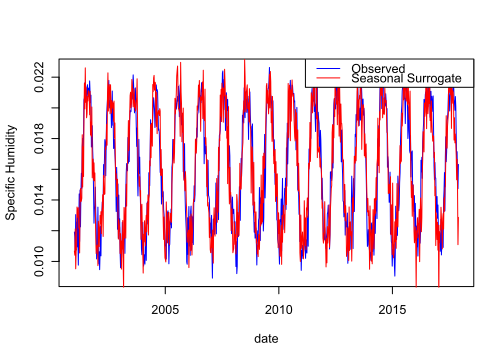

In [111]:
SH.surrs = do.call(cbind,
    lapply(1:500, function(i) {
        I_na = is.na(SH.tilde)
        out = SH.bar
        out[I_na] = NA
        out[!I_na] = out[!I_na] + sample(SH.tilde[!I_na],sum(!I_na),replace = FALSE)
        return(out)
    })
)
options(repr.plot.width=7,repr.plot.height=5)
plot(df.in$date,df.in$SH,type='l',col='blue',xlab='date',ylab='Specific Humidity')
lines(df.in$date,SH.surrs[,1],col='red')
legend( x="topright", legend=c("Observed","Seasonal Surrogate"), col=c("blue","red"), lwd=1, lty=c(1,1),bg='white')

In [112]:
block_temp = df.in %>% select(flu,SH)
lib_ccm = c(1,NROW(df.in))

out.temp = do.call(
    rbind,
    lapply(1:8, function(E_i) {
        pred_ccm = make_pred_nozero(block_temp$flu,E_i)
        ccm(block=block_temp,
            E=E_i,
            lib=lib_ccm,
            pred=pred_ccm,
            lib_sizes = NROW(block_temp),
            exclusion_radius=0,
            random_libs = FALSE,
            num_sample=1,
            tp = -1,
            lib_column = 1,
            target_column = 2, 
            silent = TRUE) }
    )
)

E_star = out.temp$E[which.max(out.temp$rho)]
E_star

out.temp

[1] 8

E,tau,tp,num_neighbors,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
1,1,-1,2,1,2,867,861,0.2310955,0.003480022,0.004344721
2,1,-1,3,1,2,867,862,0.3195053,0.003202481,0.003988431
3,1,-1,4,1,2,866,863,0.4292191,0.002880868,0.003596797
4,1,-1,5,1,2,865,865,0.4552430,0.002797270,0.003488616
5,1,-1,6,1,2,864,864,0.4854366,0.002725609,0.003398014
6,1,-1,7,1,2,863,863,0.5176685,0.002644375,0.003304786
7,1,-1,8,1,2,862,862,0.5628718,0.002532678,0.003160555
8,1,-1,9,1,2,861,861,0.5962950,0.002431219,0.003058230


In [113]:
pred_ccm = make_pred_nozero(block_temp$flu,E_star)
df.out.ccm = ccm(block=block_temp,
                    E=E_star,
                    lib=lib_ccm,
                    pred = pred_ccm,
                    lib_sizes = NROW(block_temp),
                    exclusion_radius=0,
                    random_libs = FALSE,
                    num_sample=1,
                    tp = 0, 
                    silent = TRUE)
df.out.ccm

E,tau,tp,num_neighbors,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
8,1,0,9,1,2,861,861,0.5894434,0.002455797,0.003077392


In [114]:
df.out.ccm.surr = data.frame()

for (i_surr in 1:dim(SH.surrs)[2]) {
    block_temp = data.frame(flu=df.in$flu,SH=SH.surrs[,i_surr])
    out.temp = do.call(
        rbind,
        lapply(1:8, function(E_i){
            pred_ccm = make_pred_nozero(block_temp$flu,E_i)
            ccm(block=block_temp,
                E=E_i,
                lib=lib_ccm,
                pred=pred_ccm,
                lib_sizes = NROW(block_temp),
                exclusion_radius=0,
                random_libs = FALSE,
                num_sample=1,
                tp = -1,
                lib_column = 1,
                target_column = 2, 
                silent=TRUE)
            }
        )
    )
    
    E_star = out.temp$E[which.max(out.temp$rho)]
    pred_ccm = make_pred_nozero(block_temp$flu,E_star)
    out.temp = ccm(block = block_temp,
                    E = E_star,
                    lib = lib_ccm,
                    pred = pred_ccm,
                    lib_sizes = NROW(block_temp),
                    exclusion_radius = 0,
                    random_libs = FALSE,
                    num_sample=1,
                    tp = 0,
                    silent=TRUE)
    df.out.ccm.surr <- df.out.ccm.surr %>% bind_rows(out.temp)
}

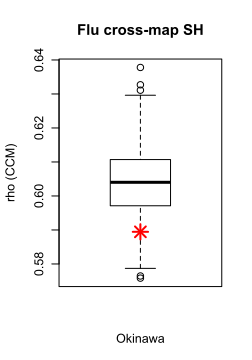

In [116]:
options(repr.plot.width=3.5,repr.plot.height=5)
boxplot(df.out.ccm.surr$rho, ylab='rho (CCM)', xlab=prefect, main='Flu cross-map SH')
points(1,df.out.ccm$rho, pch=8, col='red', cex=2, lwd=2)

In [119]:
qs=c(.05,.25, .5, .75,.95)
data.frame(value=quantile(df.out.ccm.surr$rho, qs)) -> df
df$names <- paste0("q",rownames(df))
df %>%
    mutate(names=substr(names,1,nchar(names)-1)) %>%
    spread(names,value) %>%
    mutate(Prefecture=prefect) %>%
    mutate(ccm=df.out.ccm$rho)

q25,q5,q50,q75,q95,Prefecture,ccm
0.5971144,0.586776,0.6040179,0.6106761,0.6215945,Okinawa,0.5894434


# For many prefectures

## Specific humidity

In [131]:
read.csv('Japan_by_prefecture.csv',header = TRUE) %>%
    .$Prefecture %>%
    unique -> prefects
prefects

[1] Hokkaido  Aomori    Iwate     Miyagi    Akita     Yamagata  Fukushima
 [8] Ibaraki   Tochigi   Gunma     Saitama   Chiba     Tokyo     Kanagawa 
[15] Niigata   Toyama    Ishikawa  Fukui     Yamanashi Nagano    Gifu     
[22] Shizuoka  Aichi     Mie       Shiga     Kyoto     Osaka     Hyogo    
[29] Nara      Wakayama  Tottori   Shimane   Okayama   Hiroshima Yamaguchi
[36] Tokushima Kagawa    Ehime     Kochi     Fukuoka   Saga      Nagasaki 
[43] Kumamoto  Oita      Miyazaki  Kagoshima Okinawa  
47 Levels: Aichi Akita Aomori Chiba Ehime Fukui Fukuoka Fukushima ... Yamanashi

In [151]:
DF = data.frame()
for (prefect in prefects) {
    message(prefect)
    
    df.in = read.csv('Japan_by_prefecture.csv',header = TRUE) %>%
        filter(Prefecture == prefect) %>%
        select(-Prefecture) %>%
        filter(Year>=yearMin) %>%
        left_join(Calendar,by=c("Year","Week")) %>%
        select(-Year,-Week) %>%
        rename(flu=Flu) %>%
        select(date,flu,everything()) -> df.in

    out = yearday_anom(df.in$date,df.in$SH)
    SH.bar = out$mean
    SH.tilde = out$anomaly
    
    SH.surrs = do.call(cbind,
        lapply(1:100, function(i) {
            I_na = is.na(SH.tilde)
            out = SH.bar
            out[I_na] = NA
            out[!I_na] = out[!I_na] + sample(SH.tilde[!I_na],sum(!I_na),replace = FALSE)
            return(out)
        })
    )
    
    block_temp = df.in %>% select(flu,SH)
    lib_ccm = c(1,NROW(df.in))

    out.temp = do.call(
        rbind,
        lapply(1:8, function(E_i) {
            pred_ccm = make_pred_nozero(block_temp$flu,E_i)
            ccm(block=block_temp,
                E=E_i,
                lib=lib_ccm,
                pred=pred_ccm,
                lib_sizes = NROW(block_temp),
                exclusion_radius=0,
                random_libs = FALSE,
                num_sample=1,
                tp = -1,
                lib_column = 1,
                target_column = 2, 
                silent = TRUE) }
        )
    )

    E_star = out.temp$E[which.max(out.temp$rho)]
    
    pred_ccm = make_pred_nozero(block_temp$flu,E_star)
    df.out.ccm = ccm(block=block_temp,
                        E=E_star,
                        lib=lib_ccm,
                        pred = pred_ccm,
                        lib_sizes = NROW(block_temp),
                        exclusion_radius=0,
                        random_libs = FALSE,
                        num_sample=1,
                        tp = 0, 
                        silent = TRUE)
    
    df.out.ccm.surr = data.frame()

    for (i_surr in 1:dim(SH.surrs)[2]) {
        block_temp = data.frame(flu=df.in$flu,SH=SH.surrs[,i_surr])
        out.temp = do.call(
            rbind,
            lapply(1:8, function(E_i){
                pred_ccm = make_pred_nozero(block_temp$flu,E_i)
                ccm(block=block_temp,
                    E=E_i,
                    lib=lib_ccm,
                    pred=pred_ccm,
                    lib_sizes = NROW(block_temp),
                    exclusion_radius=0,
                    random_libs = FALSE,
                    num_sample=1,
                    tp = -1,
                    lib_column = 1,
                    target_column = 2, 
                    silent=TRUE)
                }
            )
        )

        E_star = out.temp$E[which.max(out.temp$rho)]
        pred_ccm = make_pred_nozero(block_temp$flu,E_star)
        out.temp = ccm(block = block_temp,
                        E = E_star,
                        lib = lib_ccm,
                        pred = pred_ccm,
                        lib_sizes = NROW(block_temp),
                        exclusion_radius = 0,
                        random_libs = FALSE,
                        num_sample=1,
                        tp = 0,
                        silent=TRUE)
        df.out.ccm.surr <- df.out.ccm.surr %>% bind_rows(out.temp)
    }
    
    qs=c(.05,.25, .5, .75,.95)
    data.frame(value=quantile(df.out.ccm.surr$rho, qs)) -> df
    df$names <- paste0("q",rownames(df))
    df %<>%
        mutate(names=substr(names,1,nchar(names)-1)) %>%
        spread(names,value) %>%
        mutate(Prefecture=prefect) %>%
        mutate(ccm=df.out.ccm$rho)

    DF %<>% bind_rows(df)
}

DF

Hokkaido
Aomori
Iwate
Miyagi
Akita
Yamagata
Fukushima
Ibaraki
Tochigi
Gunma
Saitama
Chiba
Tokyo
Kanagawa
Niigata
Toyama
Ishikawa
Fukui
Yamanashi
Nagano
Gifu
Shizuoka
Aichi
Mie
Shiga
Kyoto
Osaka
Hyogo
Nara
Wakayama
Tottori
Shimane
Okayama
Hiroshima
Yamaguchi
Tokushima
Kagawa
Ehime
Kochi
Fukuoka
Saga
Nagasaki
Kumamoto
Oita
Miyazaki
Kagoshima
Okinawa


q25,q5,q50,q75,q95,Prefecture,ccm
0.7992740,0.7946597,0.8023943,0.8060546,0.8105495,Hokkaido,0.7997496
0.6546330,0.6482005,0.6609417,0.6684531,0.6748833,Aomori,0.6524188
0.7745365,0.7695413,0.7779705,0.7818281,0.7877821,Iwate,0.7848002
0.7851922,0.7801726,0.7888474,0.7935294,0.7979236,Miyagi,0.8014410
0.7071937,0.6973078,0.7125346,0.7173129,0.7268302,Akita,0.7168442
0.7482512,0.7420989,0.7523195,0.7576640,0.7649288,Yamagata,0.7596364
0.7909827,0.7849480,0.7945763,0.7983537,0.8021677,Fukushima,0.8047774
0.7586021,0.7521902,0.7617820,0.7652070,0.7694270,Ibaraki,0.7660418
0.7066152,0.6997741,0.7127354,0.7173528,0.7242290,Tochigi,0.7126993
0.7580980,0.7530636,0.7635463,0.7685987,0.7730685,Gunma,0.7587286


In [152]:
filename = "../Source/Climate/Locations.xlsx"
read_excel(filename, range=cell_cols("A:C")) -> dfGeo
dfGeo %>% arrange(desc(Lon),desc(Lat)) %>%
    .$Prefecture -> prefectLevels
prefectLevels

[1] "Hokkaido"  "Iwate"     "Aomori"    "Miyagi"    "Fukushima" "Akita"    
 [7] "Yamagata"  "Tochigi"   "Ibaraki"   "Chiba"     "Niigata"   "Saitama"  
[13] "Tokyo"     "Kanagawa"  "Gunma"     "Yamanashi" "Shizuoka"  "Nagano"   
[19] "Toyama"    "Gifu"      "Aichi"     "Ishikawa"  "Fukui"     "Mie"      
[25] "Shiga"     "Nara"      "Kyoto"     "Osaka"     "Wakayama"  "Hyogo"    
[31] "Tokushima" "Tottori"   "Okayama"   "Kagawa"    "Kochi"     "Shimane"  
[37] "Ehime"     "Hiroshima" "Yamaguchi" "Oita"      "Miyazaki"  "Kumamoto" 
[43] "Fukuoka"   "Kagoshima" "Saga"      "Nagasaki"  "Okinawa"

Warning message:
"Ignoring unknown parameters: width"

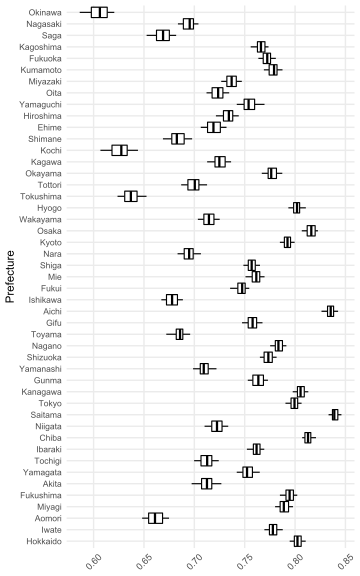

In [155]:
options(repr.plot.width=5,repr.plot.height=8)

DF %>%
    ggplot(aes(factor(Prefecture,level=prefectLevels))) +
        geom_boxplot(
            aes(ymin = q5, lower = q25, middle = q50, upper = q75, ymax = q95),
            stat = "identity", fill='white', color="black", size=.4, width=.1) +
        theme_minimal() + 
        coord_flip() +
        labs(x="Prefecture") +
        theme(axis.text.y = element_text(size=8), 
              panel.grid.minor = element_blank(),
              axis.text.x = element_text(angle = 45, vjust = .5, hjust = .5),
              axis.ticks = element_blank())

## Temperature

In [156]:
DF.T = data.frame()
for (prefect in prefects) {
    message(prefect)
    
    df.in = read.csv('Japan_by_prefecture.csv',header = TRUE) %>%
        filter(Prefecture == prefect) %>%
        select(-Prefecture) %>%
        filter(Year>=yearMin) %>%
        left_join(Calendar,by=c("Year","Week")) %>%
        select(-Year,-Week) %>%
        rename(flu=Flu) %>%
        select(date,flu,everything()) -> df.in

    out = yearday_anom(df.in$date,df.in$T)
    T.bar = out$mean
    T.tilde = out$anomaly
    
    T.surrs = do.call(cbind,
        lapply(1:100, function(i) {
            I_na = is.na(T.tilde)
            out = T.bar
            out[I_na] = NA
            out[!I_na] = out[!I_na] + sample(T.tilde[!I_na],sum(!I_na),replace = FALSE)
            return(out)
        })
    )
    
    block_temp = df.in %>% select(flu,T)
    lib_ccm = c(1,NROW(df.in))

    out.temp = do.call(
        rbind,
        lapply(1:8, function(E_i) {
            pred_ccm = make_pred_nozero(block_temp$flu,E_i)
            ccm(block=block_temp,
                E=E_i,
                lib=lib_ccm,
                pred=pred_ccm,
                lib_sizes = NROW(block_temp),
                exclusion_radius=0,
                random_libs = FALSE,
                num_sample=1,
                tp = -1,
                lib_column = 1,
                target_column = 2, 
                silent = TRUE) }
        )
    )

    E_star = out.temp$E[which.max(out.temp$rho)]
    
    pred_ccm = make_pred_nozero(block_temp$flu,E_star)
    df.out.ccm = ccm(block=block_temp,
                        E=E_star,
                        lib=lib_ccm,
                        pred = pred_ccm,
                        lib_sizes = NROW(block_temp),
                        exclusion_radius=0,
                        random_libs = FALSE,
                        num_sample=1,
                        tp = 0, 
                        silent = TRUE)
    
    df.out.ccm.surr = data.frame()

    for (i_surr in 1:dim(T.surrs)[2]) {
        block_temp = data.frame(flu=df.in$flu,T=T.surrs[,i_surr])
        out.temp = do.call(
            rbind,
            lapply(1:8, function(E_i){
                pred_ccm = make_pred_nozero(block_temp$flu,E_i)
                ccm(block=block_temp,
                    E=E_i,
                    lib=lib_ccm,
                    pred=pred_ccm,
                    lib_sizes = NROW(block_temp),
                    exclusion_radius=0,
                    random_libs = FALSE,
                    num_sample=1,
                    tp = -1,
                    lib_column = 1,
                    target_column = 2, 
                    silent=TRUE)
                }
            )
        )

        E_star = out.temp$E[which.max(out.temp$rho)]
        pred_ccm = make_pred_nozero(block_temp$flu,E_star)
        out.temp = ccm(block = block_temp,
                        E = E_star,
                        lib = lib_ccm,
                        pred = pred_ccm,
                        lib_sizes = NROW(block_temp),
                        exclusion_radius = 0,
                        random_libs = FALSE,
                        num_sample=1,
                        tp = 0,
                        silent=TRUE)
        df.out.ccm.surr <- df.out.ccm.surr %>% bind_rows(out.temp)
    }
    
    qs=c(.05,.25, .5, .75,.95)
    data.frame(value=quantile(df.out.ccm.surr$rho, qs)) -> df
    df$names <- paste0("q",rownames(df))
    df %<>%
        mutate(names=substr(names,1,nchar(names)-1)) %>%
        spread(names,value) %>%
        mutate(Prefecture=prefect) %>%
        mutate(ccm=df.out.ccm$rho)

    DF.T %<>% bind_rows(df)
}

DF.T

Hokkaido
Aomori
Iwate
Miyagi
Akita
Yamagata
Fukushima
Ibaraki
Tochigi
Gunma
Saitama
Chiba
Tokyo
Kanagawa
Niigata
Toyama
Ishikawa
Fukui
Yamanashi
Nagano
Gifu
Shizuoka
Aichi
Mie
Shiga
Kyoto
Osaka
Hyogo
Nara
Wakayama
Tottori
Shimane
Okayama
Hiroshima
Yamaguchi
Tokushima
Kagawa
Ehime
Kochi
Fukuoka
Saga
Nagasaki
Kumamoto
Oita
Miyazaki
Kagoshima
Okinawa


q25,q5,q50,q75,q95,Prefecture,ccm
0.8017733,0.7973857,0.8042849,0.8071278,0.8106252,Hokkaido,0.8062597
0.7160582,0.7080242,0.7198893,0.7237670,0.7299168,Aomori,0.7212442
0.7942480,0.7905995,0.7979395,0.8004983,0.8048277,Iwate,0.8039225
0.7875200,0.7842833,0.7915989,0.7946907,0.7989896,Miyagi,0.7948257
0.7524334,0.7460537,0.7575679,0.7604477,0.7645318,Akita,0.7592749
0.7698383,0.7643869,0.7736114,0.7775549,0.7807990,Yamagata,0.7713653
0.8183915,0.8145697,0.8216546,0.8243701,0.8280201,Fukushima,0.8288693
0.8009482,0.7967530,0.8032918,0.8065751,0.8106995,Ibaraki,0.8098034
0.7557615,0.7510390,0.7607125,0.7651555,0.7698922,Tochigi,0.7588677
0.7876487,0.7806869,0.7918001,0.7949985,0.7997426,Gunma,0.7920892


Warning message:
"Ignoring unknown parameters: width"

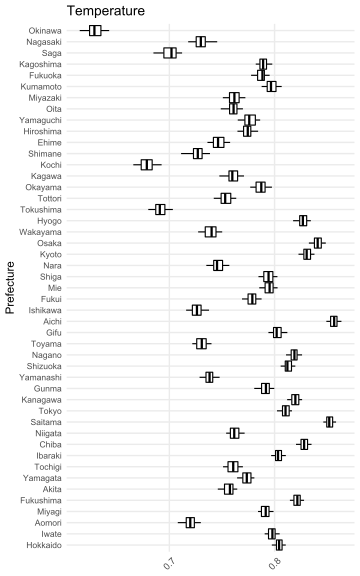

In [157]:
options(repr.plot.width=5,repr.plot.height=8)

DF.T %>%
    ggplot(aes(factor(Prefecture,level=prefectLevels))) +
        geom_boxplot(
            aes(ymin = q5, lower = q25, middle = q50, upper = q75, ymax = q95),
            stat = "identity", fill='white', color="black", size=.4, width=.1) +
        theme_minimal() + 
        coord_flip() +
        labs(x="Prefecture",title="Temperature") +
        theme(axis.text.y = element_text(size=8), 
              panel.grid.minor = element_blank(),
              axis.text.x = element_text(angle = 45, vjust = .5, hjust = .5),
              axis.ticks = element_blank())